In [1]:
from pathlib import Path
from pyagnps import climate
import xarray as xr
import geopandas as gpd
import math

C:\Users\Luc\projects\pyagnps\src\pyagnps\subannagnps.py:5: UserWarning: Please install GDAL (see install_gdal.py). The subannagnps module will not work without it
  warnings.warn("Please install GDAL (see install_gdal.py). The subannagnps module will not work without it")
C:\Users\Luc\projects\pyagnps\src\pyagnps\topagnps.py:8: UserWarning: Please install GDAL (see install_gdal.py). The topagnps module will not work without it
  warnings.warn("Please install GDAL (see install_gdal.py). The topagnps module will not work without it")


In [2]:
START_DATE = '2020-01-01'
END_DATE = '2020-01-03'
product = 'NLDAS_FORA0125_H.2.0'

chunk_frac_tot = 1.0

In [3]:
# from cli import aggregate_daily_timezone_claude as adc
from cli.aggregate_daily_timezone_claude import *

In [4]:
nldas_data_dir = Path('../../inputs/climate/')
files_dir = nldas_data_dir / 'FORA'


In [5]:
grid_gmt_offset = gpd.read_file(nldas_data_dir / 'NLDAS_GRID_LAT_LON_GMT_OFFSET.gpkg')
n_grd = gpd.read_file(nldas_data_dir / 'NLDAS2_GRID_CENTROIDS_epsg4326.gpkg')

In [6]:
oneday = relativedelta(days=1)

In [7]:
start_date = get_date_from_string(START_DATE, outputtype=datetime)
end_date = get_date_from_string(END_DATE, outputtype=datetime) + oneday # add 1 day so that the last date is included

total_duration = end_date - start_date
frac_dur = chunk_frac_tot * total_duration
time_processing_chunk = relativedelta(days=math.ceil(frac_dur.total_seconds()/(24*3600))) # rounded up to the nearest day

In [8]:
# USA gmt_min and gmt_max
gmt_offset_min = grid_gmt_offset['GMT_OFFSET'].min()
gmt_offset_max = grid_gmt_offset['GMT_OFFSET'].max()

print(f"gmt_offset_min: {gmt_offset_min}, gmt_offset_max: {gmt_offset_max}")

gmt_offset_min: -8, gmt_offset_max: -4


In [9]:
# def get_gmt_offset(lon, lat, grid_gmt_offset):
#     return grid_gmt_offset.loc[(grid_gmt_offset['lon'] == lon) & (grid_gmt_offset['lat'] == lat)]['GMT_OFFSET'].values[0]

# Convert the DataFrame to a dictionary for fast lookup
gmt_offset_dict = {(row['lon'], row['lat']): row['GMT_OFFSET'] for _, row in grid_gmt_offset.iterrows()}

# Define a function to map (lon, lat) to GMT_OFFSET
def get_gmt_offset(lon, lat):
    return gmt_offset_dict.get((lon, lat), None)  # Use None or a default value if no match is found

In [60]:

# with Client() as client:

    # print(client)

    # get the files for each dataset type requested
agg_list = []

# curr_date = start_date + relativedelta(hours=-float(gmt_offset_min)) # THE LOCAL GMT OFFSET IS ADDED HERE. I NEED TO DO MINUS TO EXPRESS IT IN UTC
# end_date_proc = end_date + relativedelta(hours=-float(gmt_offset_max)) # THE LOCAL GMT OFFSET IS ADDED HERE. I NEED TO DO MINUS TO EXPRESS IT IN UTC
curr_date = start_date # THE LOCAL GMT OFFSET IS ADDED HERE. I NEED TO DO MINUS TO EXPRESS IT IN UTC
end_date_proc = end_date

netcdf_file_list = []

while curr_date < end_date_proc:

    if (end_date_proc - curr_date).days < 365*time_processing_chunk.years + 30*time_processing_chunk.months + time_processing_chunk.days:
        time_processing_chunk = end_date_proc - curr_date
        time_processing_chunk = relativedelta(seconds=int(time_processing_chunk.total_seconds()), 
                                                microseconds=time_processing_chunk.microseconds)

    # next_date = curr_date + time_processing_chunk
    # print(f'{datetime.now()} - Aggregating {curr_date.year}-{curr_date.month}-{curr_date.day} (UTC TIME, GMT OFFSET {gmt_offset})')
    
    # Read dataset
    ds = climate.read_dataset(files_dir, curr_date+relativedelta(hours=-float(gmt_offset_max)), # We make sure we cover the period that's gre
                              time_processing_chunk+relativedelta(hours=-float(gmt_offset_min)),
                              product=product, augment=True)

    # Create field that maps every lat, lon pair to the value in grid_gmt_offset
    # Apply the function to the dataset
    lon, lat = xr.broadcast(ds.lon, ds.lat)

    # Add the new field to the dataset
    ds['GMT_OFFSET'] = xr.apply_ufunc(get_gmt_offset, lon, lat, vectorize=True)
    ds['GMT_OFFSET'].attrs['units'] = 'hours'
    # ds = localize_time(ds)

    grouped = ds.groupby('GMT_OFFSET')

    grouped_agg_list = []
    for gmt_offset, group in grouped:
        # Compute localized time for each group
        group['time_local'] = group['time'].values + pd.to_timedelta(gmt_offset, unit='h')


        agg = climate.aggregate_forcing_data_daily(group)
        agg = agg.compute()
        grouped_agg_list.append(agg.unstack('stacked_lon_lat'))

    combined_ds = grouped_agg_list[0]

    for ds_tz in grouped_agg_list[1:]:
        combined_ds = combined_ds.combine_first(ds_tz)

    # if grouped_agg_list:
    #     combined_agg = xr.combine_by_coords(grouped_agg_list, combine_attrs='override')

        # for t in combined_agg.time.values:
        #     combined_agg_t = combined_agg.sel(time=t)
        #     daystamp = pd.to_datetime(combined_agg_t.time.values)
        #     # filename = f'{netcdf_fileroot}A{daystamp.year}{daystamp.month:02d}{daystamp.day:02d}.020.nc'
        #     # agg_t.to_netcdf(os.path.join(output_dir_agg_netcdf, filename), compute=True)
        #     # netcdf_file_list.append(os.path.join(output_dir_agg_netcdf, filename))

        # agg_list.append(agg)
        # Adjust the current date and time_processing_chunk based on the GMT_OFFSET

        # print(f'Grouping by GMT_OFFSET {gmt_offset}') 

        # if 'NLDAS' in product:

        #     # Aggregate the NLDAS data
        #     agg = pna.aggregate_nldas_data_daily(group)


        # if 'FORA' in product:

        #     # Aggregate the forcing data
        #     agg = pna.aggregate_forcing_data_daily(ds)
        
        # elif 'NOAH' in product:

        #     # Aggregate NOAH data
        #     agg = pna.aggregate_noah_data_daily(ds)

        # agg = agg.compute()

        # Write the aggregated forcing data
        # for t in agg.time.values:

        #     agg_t = agg.sel(time=t)

        #     try:
        #         daystamp = pd.to_datetime(agg_t.time.values[0])
        #     except:
        #         daystamp = pd.to_datetime(agg_t.time.values)

        #     filename = f'{netcdf_fileroot}A{daystamp.year}{daystamp.month:02d}{daystamp.day:02d}.020.nc'
        #     agg_t.to_netcdf(os.path.join(output_dir_agg_netcdf, filename), compute=True)

        #     netcdf_file_list.append(os.path.join(output_dir_agg_netcdf, filename))

        # agg_list.append(agg)
        
    curr_date += time_processing_chunk

C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1196: UserWarning: no explicit representation of timezones available for np.datetime64
  from_date = np.datetime64(from_date)
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1197: UserWarning: no explicit representation of timezones available for np.datetime64
  to_date = np.datetime64(to_date)
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1454: UserWarning: no explicit representation of timezones available for np.datetime64
  start_date = np.datetime64(start_date, 'D')
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1455: UserWarning: no explicit representation of timezones available for np.datetime64
  end_date = np.datetime64(end_date, 'D')
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1456: UserWarning: no explicit representation of timezones available for np.datetime64
  mid_date = np.datetime64(mid_date, 'D')
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1492: UserWarning: Converting non-nanosecon

In [ ]:

# with Client() as client:

    # print(client)

    # get the files for each dataset type requested
agg_list = []

# curr_date = start_date + relativedelta(hours=-float(gmt_offset_min)) # THE LOCAL GMT OFFSET IS ADDED HERE. I NEED TO DO MINUS TO EXPRESS IT IN UTC
# end_date_proc = end_date + relativedelta(hours=-float(gmt_offset_max)) # THE LOCAL GMT OFFSET IS ADDED HERE. I NEED TO DO MINUS TO EXPRESS IT IN UTC
curr_date = start_date # THE LOCAL GMT OFFSET IS ADDED HERE. I NEED TO DO MINUS TO EXPRESS IT IN UTC
end_date_proc = end_date

netcdf_file_list = []

while curr_date < end_date_proc:

    if (end_date_proc - curr_date).days < 365*time_processing_chunk.years + 30*time_processing_chunk.months + time_processing_chunk.days:
        time_processing_chunk = end_date_proc - curr_date
        time_processing_chunk = relativedelta(seconds=int(time_processing_chunk.total_seconds()), 
                                                microseconds=time_processing_chunk.microseconds)

    # next_date = curr_date + time_processing_chunk
    # print(f'{datetime.now()} - Aggregating {curr_date.year}-{curr_date.month}-{curr_date.day} (UTC TIME, GMT OFFSET {gmt_offset})')
    
    # Read dataset
    ds = climate.read_dataset(files_dir, curr_date+relativedelta(hours=-float(gmt_offset_max)), # We make sure we cover the period that's gre
                              time_processing_chunk+relativedelta(hours=-float(gmt_offset_min)),
                              product=product, augment=True)

    # Create field that maps every lat, lon pair to the value in grid_gmt_offset
    # Apply the function to the dataset
    lon, lat = xr.broadcast(ds.lon, ds.lat)

    # Add the new field to the dataset
    ds['GMT_OFFSET'] = xr.apply_ufunc(get_gmt_offset, lon, lat, vectorize=True)
    ds['GMT_OFFSET'].attrs['units'] = 'hours'
    # ds = localize_time(ds)

    grouped = ds.groupby('GMT_OFFSET')

    grouped_agg_list = []
    for gmt_offset, group in grouped:
        # Compute localized time for each group
        group['time_local'] = group['time'].values + pd.to_timedelta(gmt_offset, unit='h')

        if 'FORA' in product:

            # Aggregate the forcing data
            agg = climate.aggregate_forcing_data_daily(group)
        
        # NEEDS TO BE IMPLEMENTED FOR NOAH
        # elif 'NOAH' in product:

        #     # Aggregate NOAH data
        #     agg = climate.aggregate_noah_data_daily(group)

        agg = agg.compute()
        grouped_agg_list.append(agg.unstack('stacked_lon_lat'))

    combined_agg = grouped_agg_list[0]

    for ds_tz in grouped_agg_list[1:]:
        combined_agg = combined_agg.combine_first(ds_tz)

    # if grouped_agg_list:
    #     combined_agg = xr.combine_by_coords(grouped_agg_list, combine_attrs='override')

    for t in combined_agg.time.values:
        combined_agg_t = combined_ds.sel(time=t)
        daystamp = pd.to_datetime(combined_agg_t.time.values)
        filename = f'{netcdf_fileroot}A{daystamp.year}{daystamp.month:02d}{daystamp.day:02d}.020.nc'
        # agg_t.to_netcdf(os.path.join(output_dir_agg_netcdf, filename), compute=True)
        # netcdf_file_list.append(os.path.join(output_dir_agg_netcdf, filename))

        # agg_list.append(agg)
        # Adjust the current date and time_processing_chunk based on the GMT_OFFSET

        # print(f'Grouping by GMT_OFFSET {gmt_offset}') 

        # if 'NLDAS' in product:

        #     # Aggregate the NLDAS data
        #     agg = pna.aggregate_nldas_data_daily(group)


        # if 'FORA' in product:

        #     # Aggregate the forcing data
        #     agg = pna.aggregate_forcing_data_daily(ds)
        
        # elif 'NOAH' in product:

        #     # Aggregate NOAH data
        #     agg = pna.aggregate_noah_data_daily(ds)

        # agg = agg.compute()

        # Write the aggregated forcing data
        # for t in agg.time.values:

        #     agg_t = agg.sel(time=t)

        #     try:
        #         daystamp = pd.to_datetime(agg_t.time.values[0])
        #     except:
        #         daystamp = pd.to_datetime(agg_t.time.values)

        #     filename = f'{netcdf_fileroot}A{daystamp.year}{daystamp.month:02d}{daystamp.day:02d}.020.nc'
        #     agg_t.to_netcdf(os.path.join(output_dir_agg_netcdf, filename), compute=True)

        #     netcdf_file_list.append(os.path.join(output_dir_agg_netcdf, filename))

        # agg_list.append(agg)
        
    curr_date += time_processing_chunk

C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1196: UserWarning: no explicit representation of timezones available for np.datetime64
  from_date = np.datetime64(from_date)
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1197: UserWarning: no explicit representation of timezones available for np.datetime64
  to_date = np.datetime64(to_date)
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1454: UserWarning: no explicit representation of timezones available for np.datetime64
  start_date = np.datetime64(start_date, 'D')
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1455: UserWarning: no explicit representation of timezones available for np.datetime64
  end_date = np.datetime64(end_date, 'D')
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1456: UserWarning: no explicit representation of timezones available for np.datetime64
  mid_date = np.datetime64(mid_date, 'D')
C:\Users\Luc\projects\pyagnps\src\pyagnps\climate.py:1492: UserWarning: Converting non-nanosecon

In [68]:
group['time_local']

<xarray.DataArray 'time_local' (time_local: 80)> Size: 640B
array(['2020-01-01T01:00:00.000000000', '2020-01-01T02:00:00.000000000',
       '2020-01-01T03:00:00.000000000', '2020-01-01T04:00:00.000000000',
       '2020-01-01T05:00:00.000000000', '2020-01-01T06:00:00.000000000',
       '2020-01-01T07:00:00.000000000', '2020-01-01T08:00:00.000000000',
       '2020-01-01T09:00:00.000000000', '2020-01-01T10:00:00.000000000',
       '2020-01-01T11:00:00.000000000', '2020-01-01T12:00:00.000000000',
       '2020-01-01T13:00:00.000000000', '2020-01-01T14:00:00.000000000',
       '2020-01-01T15:00:00.000000000', '2020-01-01T16:00:00.000000000',
       '2020-01-01T17:00:00.000000000', '2020-01-01T18:00:00.000000000',
       '2020-01-01T19:00:00.000000000', '2020-01-01T20:00:00.000000000',
       '2020-01-01T21:00:00.000000000', '2020-01-01T22:00:00.000000000',
       '2020-01-01T23:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-02T01:00:00.000000000', '2020-01-02T02:00:00.000000000',
       '2020-01-02T03:00:00.000000000', '2020-01-02T04:00:00.000000000',
       '2020-01-02T05:00:00.000000000', '2020-01-02T06:00:00.000000000',
       '2020-01-02T07:00:00.000000000', '2020-01-02T08:00:00.000000000',
       '2020-01-02T09:00:00.000000000', '2020-01-02T10:00:00.000000000',
       '2020-01-02T11:00:00.000000000', '2020-01-02T12:00:00.000000000',
       '2020-01-02T13:00:00.000000000', '2020-01-02T14:00:00.000000000',
       '2020-01-02T15:00:00.000000000', '2020-01-02T16:00:00.000000000',
       '2020-01-02T17:00:00.000000000', '2020-01-02T18:00:00.000000000',
       '2020-01-02T19:00:00.000000000', '2020-01-02T20:00:00.000000000',
       '2020-01-02T21:00:00.000000000', '2020-01-02T22:00:00.000000000',
       '2020-01-02T23:00:00.000000000', '2020-01-03T00:00:00.000000000',
       '2020-01-03T01:00:00.000000000', '2020-01-03T02:00:00.000000000',
       '2020-01-03T03:00:00.000000000', '2020-01-03T04:00:00.000000000',
       '2020-01-03T05:00:00.000000000', '2020-01-03T06:00:00.000000000',
       '2020-01-03T07:00:00.000000000', '2020-01-03T08:00:00.000000000',
       '2020-01-03T09:00:00.000000000', '2020-01-03T10:00:00.000000000',
       '2020-01-03T11:00:00.000000000', '2020-01-03T12:00:00.000000000',
       '2020-01-03T13:00:00.000000000', '2020-01-03T14:00:00.000000000',
       '2020-01-03T15:00:00.000000000', '2020-01-03T16:00:00.000000000',
       '2020-01-03T17:00:00.000000000', '2020-01-03T18:00:00.000000000',
       '2020-01-03T19:00:00.000000000', '2020-01-03T20:00:00.000000000',
       '2020-01-03T21:00:00.000000000', '2020-01-03T22:00:00.000000000',
       '2020-01-03T23:00:00.000000000', '2020-01-04T00:00:00.000000000',
       '2020-01-04T01:00:00.000000000', '2020-01-04T02:00:00.000000000',
       '2020-01-04T03:00:00.000000000', '2020-01-04T04:00:00.000000000',
       '2020-01-04T05:00:00.000000000', '2020-01-04T06:00:00.000000000',
       '2020-01-04T07:00:00.000000000', '2020-01-04T08:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
  * time_local   (time_local) datetime64[ns] 640B 2020-01-01T01:00:00 ... 202...

In [53]:
combined_ds = grouped_agg_list[0]

for p in grouped_agg_list[1:]:
    combined_ds = combined_ds.combine_first(p)

In [58]:
ds

<xarray.Dataset> Size: 500MB
Dimensions:         (time: 80, bnds: 2, lat: 224, lon: 464)
Coordinates:
  * lon             (lon) float32 2kB -124.9 -124.8 -124.7 ... -67.19 -67.06
  * lat             (lat) float32 896B 25.06 25.19 25.31 ... 52.69 52.81 52.94
  * time            (time) datetime64[ns] 640B 2020-01-01T05:00:00 ... 2020-0...
    spatial_ref     int64 8B 0
Dimensions without coordinates: bnds
Data variables: (12/17)
    time_bnds       (time, bnds) datetime64[ns] 1kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Tair            (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qair            (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    PSurf           (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Wind_E          (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Wind_N          (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    ...              ...
    SWdown          (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    RH              (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Tdew            (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    wind_speed      (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    wind_direction  (time, lat, lon) float32 33MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    GMT_OFFSET      (lon, lat) int64 831kB -8 -8 -8 -8 -8 -8 ... -5 -5 -5 -5 -4
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

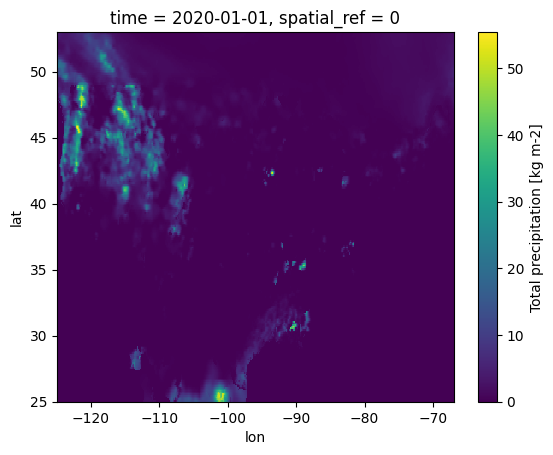

In [59]:
combined_ds.isel(time=0)['Rainf'].plot(x='lon', y='lat')

In [24]:
dd = xr.combine_nested(grouped_agg_list, concat_dim='time', combine_attrs='override')

C:\Users\Luc\AppData\Local\Temp\ipykernel_22612\1614053706.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dd = xr.combine_nested(grouped_agg_list, concat_dim='time', combine_attrs='override')
C:\Users\Luc\AppData\Local\Temp\ipykernel_22612\1614053706.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values

In [38]:
ds.lat #

<xarray.DataArray 'lat' (lat: 224)> Size: 896B
array([25.0625, 25.1875, 25.3125, ..., 52.6875, 52.8125, 52.9375],
      dtype=float32)
Coordinates:
  * lat          (lat) float32 896B 25.06 25.19 25.31 ... 52.69 52.81 52.94
    spatial_ref  int64 8B 0

In [47]:
dd = xr.combine_nested(grouped_agg_list[0:3], concat_dim='time')

C:\Users\Luc\AppData\Local\Temp\ipykernel_22612\3025957007.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dd = xr.combine_nested(grouped_agg_list[0:3], concat_dim='time')
C:\Users\Luc\AppData\Local\Temp\ipykernel_22612\3025957007.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or 

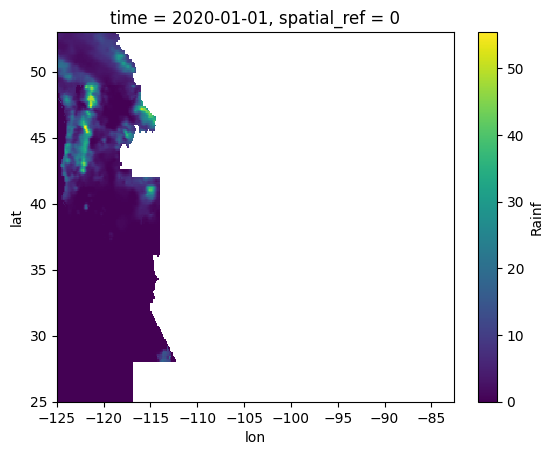

In [48]:
dd.isel(time=0)['Rainf'].plot(x='lon', y='lat')

C:\Users\Luc\AppData\Local\Temp\ipykernel_22612\2143866278.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  agg_list[0].unstack('stacked_lon_lat').isel(time=0)['Rainf'].plot(x='lon', y='lat')


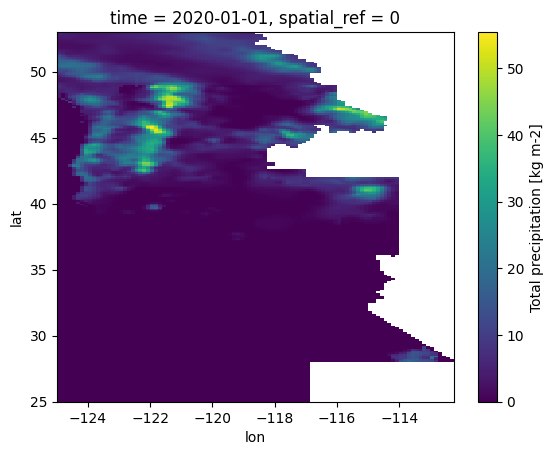

In [17]:
agg_list[0].unstack('stacked_lon_lat').isel(time=0)['Rainf'].plot(x='lon', y='lat')

In [19]:

root_dir = Path('C:/Users/Luc/projects/pyagnps/inputs/climate/FORA/')
file = root_dir / 'NLDAS_NOAH0125_H.A20200104.0000.020.nc'
# file2 = Path(r'C:\Users\Luc\projects\pyagnps\inputs\climate\FORA\NLDAS_NOAH0125_H.A20200104.0000.020.nc')
file.exists()
# file2.exists()

False

In [18]:
root_dir.exists()

True

In [122]:
for d in pd.date_range(start=start_date, end=end_date, freq='D'):
    print(d)

2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00


In [106]:
ds['time'].values + ds['GMT_OFFSET'].values

ValueError: operands could not be broadcast together with shapes (4,) (464,224) 

In [77]:
ds

<xarray.Dataset> Size: 26MB
Dimensions:         (time: 4, bnds: 2, lat: 224, lon: 464)
Coordinates:
  * lon             (lon) float32 2kB -124.9 -124.8 -124.7 ... -67.19 -67.06
  * lat             (lat) float32 896B 25.06 25.19 25.31 ... 52.69 52.81 52.94
  * time            (time) datetime64[ns] 32B 2020-01-01T05:00:00 ... 2020-01...
    spatial_ref     int64 8B 0
Dimensions without coordinates: bnds
Data variables: (12/17)
    time_bnds       (time, bnds) datetime64[ns] 64B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Tair            (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qair            (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    PSurf           (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Wind_E          (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Wind_N          (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    ...              ...
    SWdown          (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    RH              (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Tdew            (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    wind_speed      (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    wind_direction  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    GMT_OFFSET      (lon, lat) int64 831kB -8 -8 -8 -8 -8 -8 ... -5 -5 -5 -5 -4
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

In [78]:
224*464

103936

In [58]:
grouped = ds.groupby('GMT_OFFSET')
grouped

DatasetGroupBy, grouped over 'GMT_OFFSET'
5 groups with labels -8, -7, -6, -5, -4.

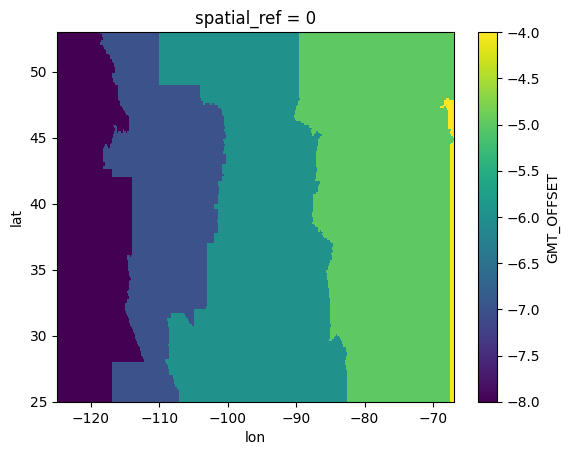

In [73]:
ds['GMT_OFFSET'].plot(x='lon', y='lat')

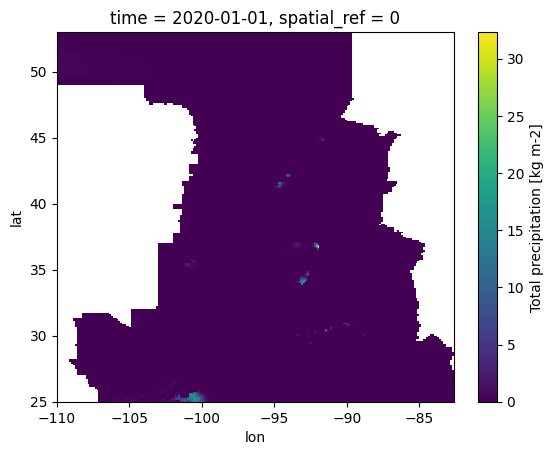

In [117]:
grouped[-6].resample(time='1D').sum().unstack('stacked_lon_lat')['Rainf'].plot(x='lon', y='lat')

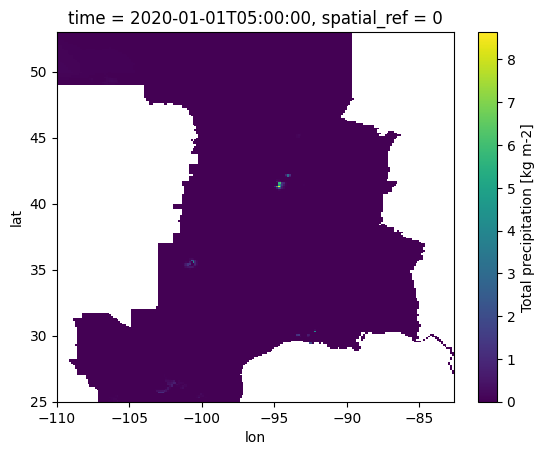

In [115]:
grouped[-6].unstack('stacked_lon_lat').isel(time=0)['Rainf'].plot(x='lon', y='lat')